# ADA Project - DataBrewers

The aim of this project is to analyze beer preference shifts across seasons and in response to weather changes, events and cultural festivities. This could significantly help professionals (brewers, marketers, etc.) by providing insights into customer preferences. 
By understanding seasonal trends, brewers can adjust their product offerings to align more closely with consumer demand. 
Moreover, as a conclusion of our research, we could suggest the best beer that would be the perfect match for each season/festivity, in the form of a time fresco. 


## Data selection and filtering
Our analysis will primarly focus on the reviews published by users based in the United State of America. The reason for this choice is that it is the country were the majority of reviews are done, and it provides us with enough data to conduct our analysis.

1. **The Herding Effect:** As explained in the paper "When Sheep Shop: Measuring Herding Effects in Product Ratings with Natural Experiments" from Gael Lederrey and Robert West, initial ratings can influence the following ones. By focusing on a single dataset, we can better control for this effect within a single user community. Including RateBeer might introduce inconsistent herding effects that could skew comparative analyses.
2. **Inconsistant Rating Standards:** Both BeerAdvocate and RateBeer communities likely develop their own informal standards for beer ratings. Focusing on a single platform like BeerAdvocate allows dor a more cohesive dataset, with users who rate within the same context, minimizing cross-platform variance.
3. **Data Sufficiency:** The BeerAdvocate dataset provides us with enough reviews and data to perform meaningful analysis and draw reliable insights.

In [1]:
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Loading

In [3]:
import sys
sys.path.append('src')

from data.dataloader import load_matched_beer_data, load_beer_advocate_data, load_rate_beer_data

# Load the matched beer data
ratings_merged, users_approx, users_merged, beers_merged, breweries_merged = load_matched_beer_data()

# Load the BeerAdvocate data
beers_ba, reviews_ba, users_ba, breweries_ba, ratings_ba = load_beer_advocate_data()

# Load the RateBeer data
beers_rb, reviews_rb, users_rb, breweries_rb, ratings_rb = load_rate_beer_data()

### Difference between the RateBeer and BeerAdvocate dataset

**Number of users**

In [4]:
# We prompt the number of users in each dataset
nb_users_rb = len(users_rb)
nb_users_ba = len(users_ba)

print("The RateBeer dataset have", nb_users_rb, "users.")
print("The BeerAdvocate dataset have", nb_users_ba, "users.")

The RateBeer dataset have 70174 users.
The BeerAdvocate dataset have 153704 users.


**Number of beers**

In [5]:
# We prompt the number of beers in each dataset
nb_beers_rb = len(beers_rb)
nb_beers_ba = len(beers_ba)

print("The RateBeer dataset have", nb_beers_rb, "beers.")
print("The BeerAdvocate dataset have", nb_beers_ba, "beers.")

The RateBeer dataset have 442081 beers.
The BeerAdvocate dataset have 280823 beers.


**Number of ratings**

In [6]:
# We prompt the numbers of ratings in each dataset using the nbr_ratings column of the beers dataset and summing them
nb_ratings_rb = beers_rb['nbr_ratings'].sum()
nb_ratings_ba = beers_ba['nbr_ratings'].sum()

print("The RateBeer dataset have", nb_ratings_rb, "ratings.")
print("The BeerAdvocate dataset have", nb_ratings_ba, "ratings.")

The RateBeer dataset have 7122074 ratings.
The BeerAdvocate dataset have 8393032 ratings.


**Numbers of reviews**

In [7]:
# Add review_id based on 16-row structure 
reviews_ba['review_id'] = reviews_ba.index // 16

# Split key-value pairs and filter valid splits
split_data_ba = reviews_ba['info'].str.split(': ', n=1, expand=True)
split_data_ba = split_data_ba[split_data_ba[1].notna()]  # Remove rows with no :

# Assign key and value columns
reviews_ba[['key', 'value']] = split_data_ba

# Pivot the table to convert key to a column
reviews_ba = reviews_ba.pivot(index='review_id', columns='key', values='value').reset_index(drop=True)

In [8]:
del split_data_ba

In [10]:
processed_reviews = []  # Temporary list to hold processed data

chunk_size = 1600

# Process the reviews_rb data in chunks
for start in range(0, len(reviews_rb), chunk_size):
    
    # Extract a chunk of data
    chunk = reviews_rb.iloc[start:start + chunk_size].copy()

    # Add review_id based on 16-row structure
    chunk['review_id'] = chunk.index // 16
    
    # Split key-value pairs
    split_data = chunk['info'].str.split(': ', n=1, expand=True)
    chunk = chunk[split_data[1].notna()]  # Keep rows with valid key-value pairs
    
    # Assign key and value columns
    chunk[['key', 'value']] = split_data
    
    # Pivot the chunk to convert key to columns
    chunk_pivoted = chunk.pivot(index='review_id', columns='key', values='value').reset_index(drop=True)
    processed_reviews.append(chunk_pivoted)

reviews_rb = pd.concat(processed_reviews, ignore_index=True)

In [11]:
# We prompt the numbers of ratings in the dataset using the nbr_ratings column of the beers dataset and summing them
nb_reviews_rb = len(reviews_rb)
nb_reviews_ba = len(reviews_ba)

print("The RateBeer dataset have", nb_reviews_rb, "reviews.")
print("The BeerAdvocate dataset have", nb_reviews_ba, "reviews.")

The RateBeer dataset have 7122074 reviews.
The BeerAdvocate dataset have 2589586 reviews.


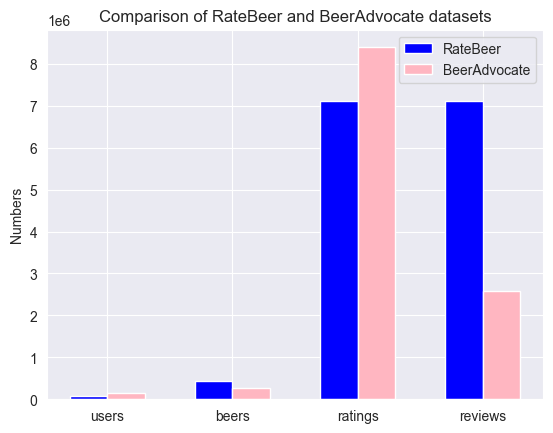

In [12]:
labels = ["users", "beers", "ratings", "reviews"]

rb_counts = [nb_users_rb, nb_beers_rb, nb_ratings_rb, nb_reviews_rb]
ba_counts = [nb_users_ba, nb_beers_ba, nb_ratings_ba, nb_reviews_ba]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
bars_rb = ax.bar(x - width/2, rb_counts, width, label='RateBeer', color='blue')
bars_ba = ax.bar(x + width/2, ba_counts, width, label='BeerAdvocate', color='lightpink')

ax.set_ylabel('Numbers')
ax.set_title('Comparison of RateBeer and BeerAdvocate datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [13]:
summary_data = {
    "Metric": ["users", "beers", "ratings", "reviews"],
    "RateBeer": [nb_users_rb, nb_beers_rb, nb_ratings_rb, nb_reviews_rb],
    "BeerAdvocate": [nb_users_ba, nb_beers_ba, nb_ratings_ba, nb_reviews_ba]
}
summary_df = pd.DataFrame(summary_data)
summary_df.style.set_caption("Summary for RateBeer and BeerAdvocate")

,Metric,RateBeer,BeerAdvocate
0,users,70174,153704
1,beers,442081,280823
2,ratings,7122074,8393032
3,reviews,7122074,2589586


The BeerAdvocate dataset provides us with enough reviews and data to perform and we will focus only on this dataset for the rest of the analysis.

### Users location analysis

In [14]:
# Separate the country and the states
users_ba['country'] = users_ba['location'].str.split(',').str[0]
users_ba['states'] = users_ba['location'].str.split(',').str[1]

In [15]:
missing_countries = users_ba['country'].isna().sum()
print(f"Number of missing 'country' entries: {missing_countries}")

Number of missing 'country' entries: 31279


In [17]:
# Replace missing 'country' values with a label "Unknown"
users_ba['country'] = users_ba['country'].fillna('Unknown')

# Compute the number of users in the top 5 countries
top5_countries = users_ba['country'].value_counts().nlargest(5)

# Compute the sum of the remaining countries (including 'Unknown' entries if any)
other_countries_count = len(users_ba) - top5_countries.sum()

# Add the "Other" countries count to the series
top_countries = pd.concat([top5_countries, pd.Series({'Other': other_countries_count})])

# Calculate percentages for each country in top_countries
top_countries_percent_ba = (top_countries / len(users_ba) * 100).round(1)

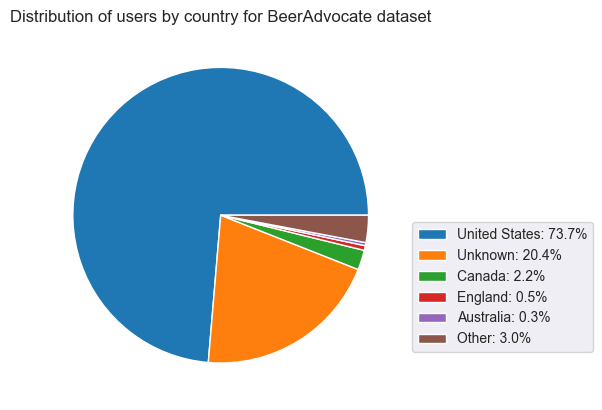

In [18]:
top_countries.plot(kind='pie', labels=None)

# Create legend with country name and percentage
top_countries_labels = [f"{country}: {percent}%" for country, percent in zip(top_countries.index, top_countries_percent_ba)]
plt.legend(labels=top_countries_labels, loc="best", bbox_to_anchor=(1, 0.5))

plt.title(f'Distribution of users by country for BeerAdvocate dataset')
plt.show()

The majority of the users are from the United States. 

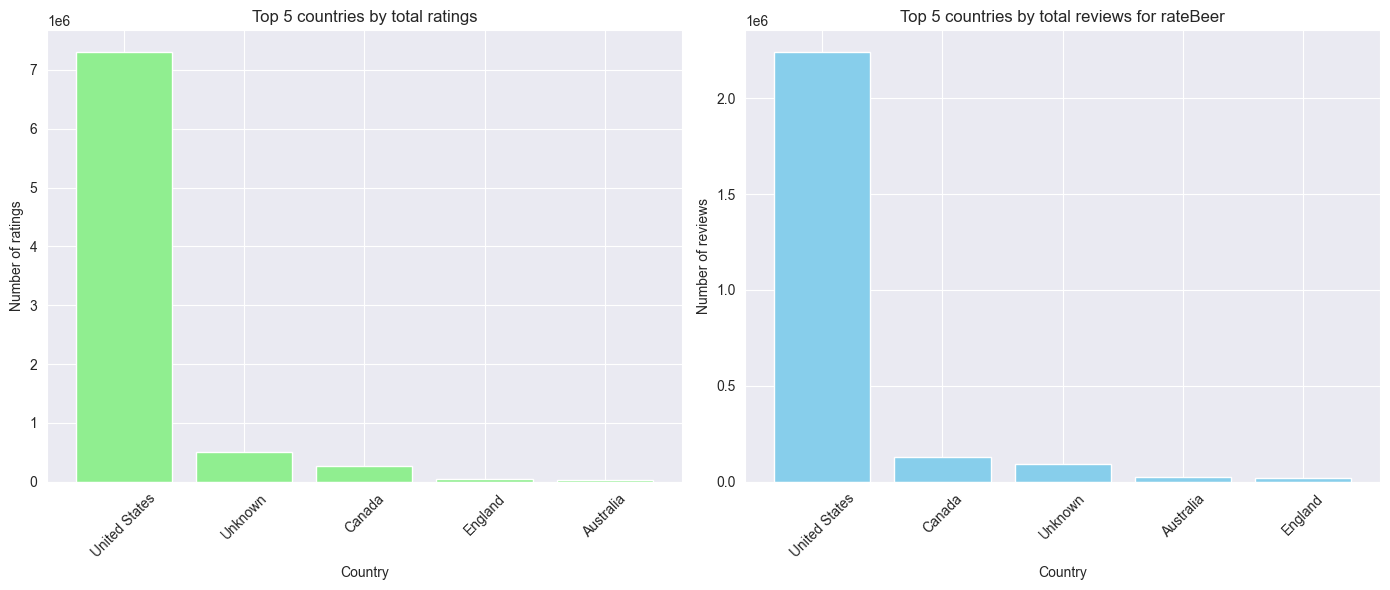

In [20]:
# Convert the number of ratings values to numeric
users_ba['nbr_ratings'] = pd.to_numeric(users_ba['nbr_ratings'], errors='coerce')
users_ba['nbr_reviews'] = pd.to_numeric(users_ba['nbr_reviews'], errors='coerce')

# Group by country and sum the ratings and the reviews
country_ratings = users_ba.groupby('country')['nbr_ratings'].sum().reset_index()
country_reviews = users_ba.groupby('country')['nbr_reviews'].sum().reset_index()

# Get the top 5 countries by number of ratings and reviews
top_countries_ratings = country_ratings.nlargest(5, 'nbr_ratings')
top_countries_reviews = country_reviews.nlargest(5, 'nbr_reviews')


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(top_countries_ratings['country'], top_countries_ratings['nbr_ratings'], color='lightgreen')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Number of ratings')
axes[0].set_title('Top 5 countries by total ratings')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(top_countries_reviews['country'], top_countries_reviews['nbr_reviews'], color='skyblue')
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Number of reviews')
axes[1].set_title('Top 5 countries by total reviews for rateBeer')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

And most of the ratings and reviews are made by american users. Therefore, we chosed to focus only on American users as this still provide us enough data

In [21]:
# We only keep users from the US
users = users_ba[users_ba['country'] == 'United States']
print("There are", len(users), "users from the United States in the BeerAdvocate dataset")

# We prompt the number of ratings made by US users using the nb_ratings column of the users dataset and summing them for users where location is contains United States 
print("Number of ratings made by US users: ", users[users['country'].str.contains('United States')]['nbr_ratings'].sum())

# We prompt the number of reviews made by US users using the nb_reviews column of the users dataset and summing them for users where location is contains United States
print("Number of reviews made by US users: ", users[users['country'].str.contains('United States')]['nbr_reviews'].sum())

There are 113223 users from the United States in the BeerAdvocate dataset
Number of ratings made by US users:  7303870
Number of reviews made by US users:  2241334


In [22]:
reviews_ba = reviews_ba.merge(users_ba[['user_id', 'location']], on='user_id', how='left')

In [23]:
# Remove the states to only have the countries
reviews_ba['country'] = reviews_ba['location'].str.split(',').str[0]

# Remove the countries to only have the states
reviews_ba['states'] = reviews_ba['location'].str.split(',').str[1]

# We only keep users from the US
reviews = reviews_ba[reviews_ba['country'] == 'United States']

Also filtering the ratings to keep only US users:

In [34]:
filtered_chunks = []
chunk_size = 1600  

for start in range(0, len(ratings_ba), chunk_size):
    # Extract a chunk of data from the ratings_rb 
    chunk = ratings_ba.iloc[start:start + chunk_size].copy()
    
    # Add rating_id based on 16-row structure
    chunk['rating_id'] = chunk.index // 16
    
    # Split key-value pairs
    split_data = chunk['info'].str.split(': ', n=1, expand=True)
    chunk = chunk[split_data[1].notna()]  # Keep only rows with valid key-value pairs
    
    # Assign key and value columns
    chunk[['key', 'value']] = split_data
    
    # Pivot the chunk to convert key to columns
    chunk_pivoted = chunk.pivot(index='rating_id', columns='key', values='value').reset_index(drop=True)
    
    # Merge with 'user_id' and 'location' from users dataset
    chunk_pivoted = chunk_pivoted.merge(users[['user_id', 'location']], on='user_id', how='left')

    # Extract 'country' and 'state' from 'location'
    chunk_pivoted['country'] = chunk_pivoted['location'].str.split(',').str[0]
    chunk_pivoted['state'] = chunk_pivoted['location'].str.split(',').str[1]

    # Filter for users from the United States
    chunk_filtered = chunk_pivoted[chunk_pivoted['country'] == 'United States']
    filtered_chunks.append(chunk_filtered)

# Concatenate all filtered chunks to create the final DataFrame
ratings = pd.concat(filtered_chunks, ignore_index=True)

**Saving the data on local**

In [38]:
reviews.to_csv('data/reviews_processed.csv.gz', index=False, compression='gzip')
ratings.to_csv('data/ratings_processed.csv.gz', index=False, compression='gzip')

**Load the data from local**

In [39]:
reviews = pd.read_csv('data/reviews_processed.csv.gz', compression='gzip')
ratings = pd.read_csv('data/ratings_processed.csv.gz', compression='gzip')

#### Analysis US states 

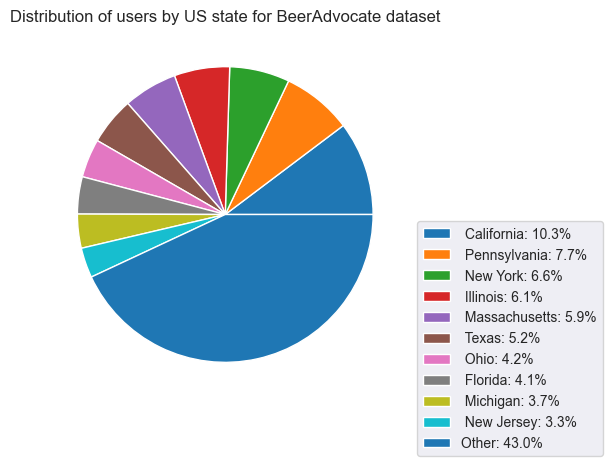

In [40]:
# Compute the number of users in the top 5 states
top10_states = users['states'].value_counts().nlargest(10)

# Compute the sum of the remaining states
other_users_count = len(users) - top10_states.sum()

# Add the "Other" states count to the series
top_states = pd.concat([top10_states, pd.Series({'Other': other_users_count})])

# Calculate percentages for each country in top_countries
top_states_percent = (top_states / len(users) * 100).round(1)

top_states.plot(kind='pie', labels=None)

# Create legend with state name and percentage
top_states_labels = [f"{state}: {percent}%" for state, percent in zip(top_states.index, top_states_percent)]
plt.legend(labels=top_states_labels, loc="best", bbox_to_anchor=(1, 0.5))

plt.title(f'Distribution of users by US state for BeerAdvocate dataset')
plt.show()

There is considerable diversity in the origins of U.S. users, with 10.3% from California, a generally warmer region, and 7.7% and 6.6% from Pennsylvania and New York, respectively, where colder climates are common.

### Beer style analysis

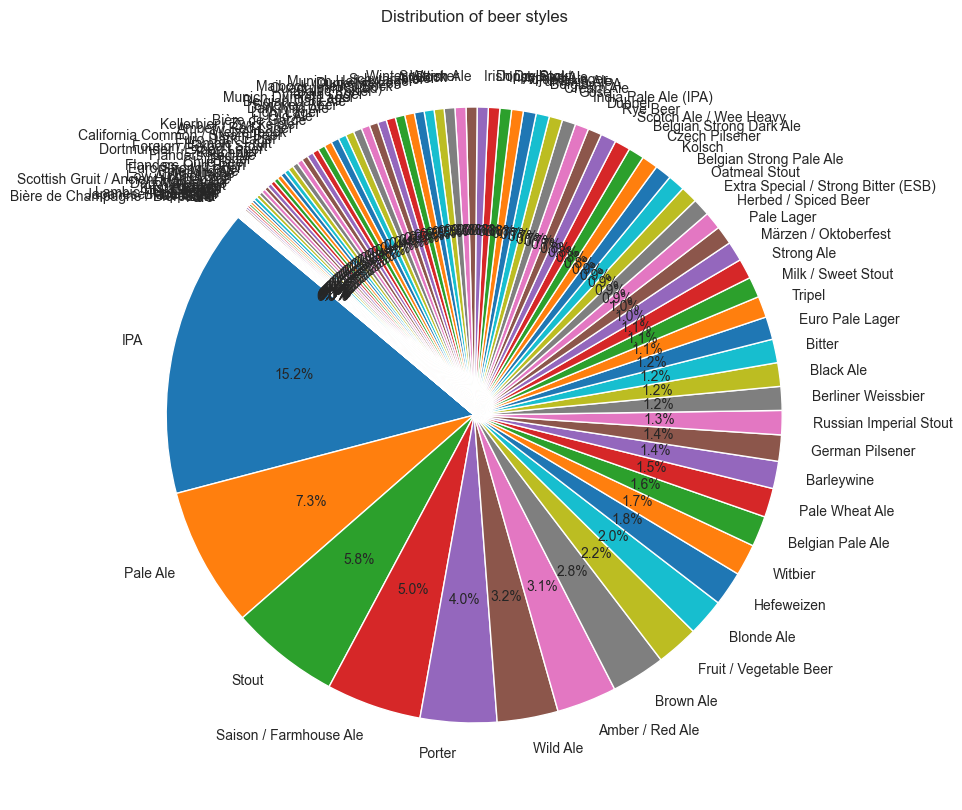

In [41]:
# Remove specific words from 'style' column in beers_ba DataFrame
beers_ba['style'] = beers_ba['style'].str.replace('American ', '')
beers_ba['style'] = beers_ba['style'].str.replace('Double / Imperial ', '')
beers_ba['style'] = beers_ba['style'].str.replace('English ', '')
beers_ba['style'] = beers_ba['style'].str.replace(' (APA)', '', regex=False)

# Count occurrences of each style
style_count = beers_ba['style'].value_counts()

plt.figure(figsize=(10, 10))
style_count.plot.pie(autopct='%1.1f%%', startangle=140)
plt.title('Distribution of beer styles')
plt.ylabel('') 
plt.show()

In [42]:
# Get counts of ratings by beer ID
ratings_count = ratings['beer_id'].value_counts().rename('count')
beers_ba = beers_ba.set_index('beer_id')

# Join ratings count with beers_ba DataFrame to get styles and names for each beer
ratings_count = ratings_count.to_frame().join(beers_ba[['style', 'beer_name']], how='left')

# Group by 'beer_name' and 'style' to get total count for each
beer_counts = ratings_count.groupby('beer_name')['count'].sum().nlargest(10)
style_counts = ratings_count.groupby('style')['count'].sum().nlargest(10)

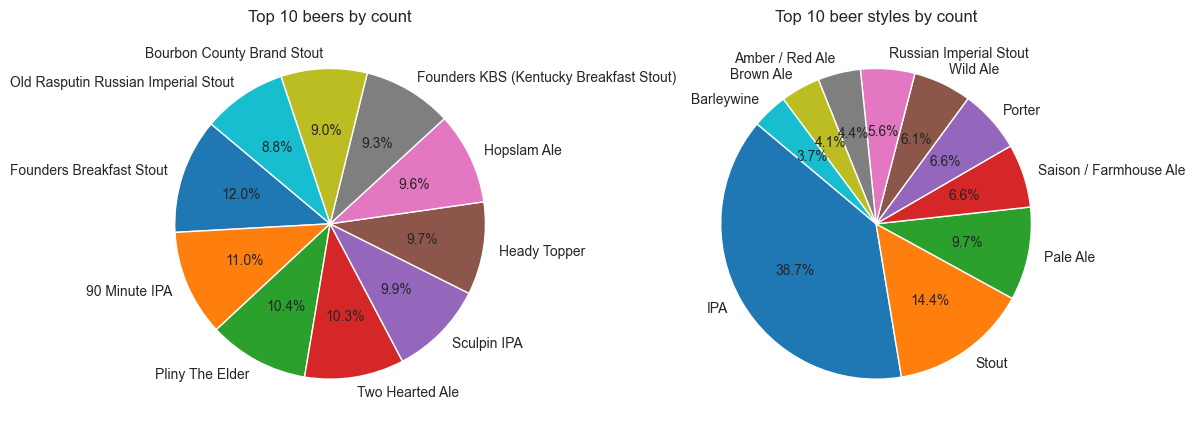

In [60]:
# Plot the pie chart for top 10 beer names
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(beer_counts, labels=beer_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 beers by count')

# Plot the pie chart for top 10 beer styles
plt.subplot(1, 2, 2)
plt.pie(style_counts, labels=style_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 beer styles by count')

plt.tight_layout()
plt.show()

### Time analysis

In [44]:
# Extract the year, month, and day
reviews['date']  = pd.to_datetime(reviews['date'], unit='s', errors='coerce')
reviews['year'] = reviews['date'].dt.year
reviews['month'] = reviews['date'].dt.month
reviews['day'] = reviews['date'].dt.day

In [45]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    elif month in [12, 1, 2]:
        return 'Winter'

In [46]:
# Separate the reviews by seasons
reviews['season'] = reviews['month'].apply(get_season)

#### Analysis over the years:

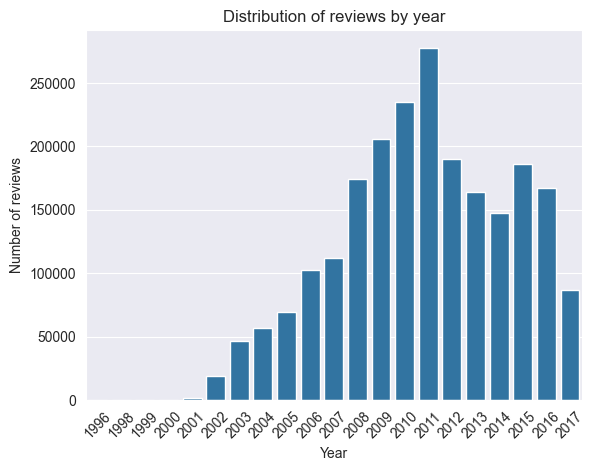

In [47]:
# Plot yearly review counts

sns.countplot(data=reviews, x='year', legend=False)
plt.title('Distribution of reviews by year')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.xticks(rotation=45)
plt.show()

We can see that before 2002, there are few reviews given by users on the BeerAdvocate website. We can choose a threshold of a minimum of 70'000 reviews by year to have enough reviews published by year to analyze the change over a year.

In [48]:
# Count the number of reviews by year
reviews_per_year = reviews['year'].value_counts()

# Filter to keep only years with more than 70'000 reviews
years_above_threshold = reviews_per_year[reviews_per_year > 70000].index
reviews = reviews[reviews['year'].isin(years_above_threshold)]

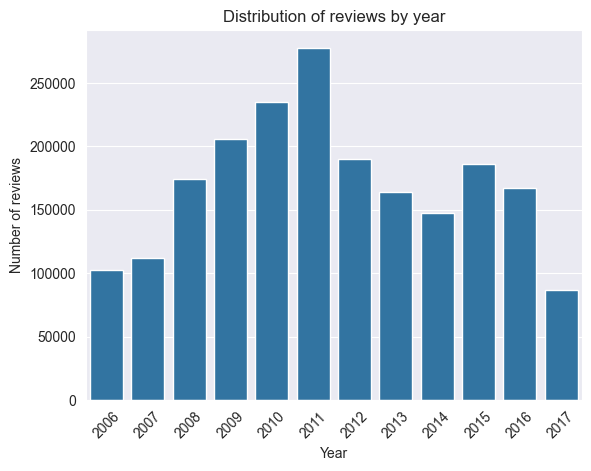

In [49]:
sns.countplot(data=reviews, x='year')
plt.title('Distribution of reviews by year')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.xticks(rotation=45)
plt.show()

We now have only reviews published between 2006 and 2017

#### Analysis across the seasons

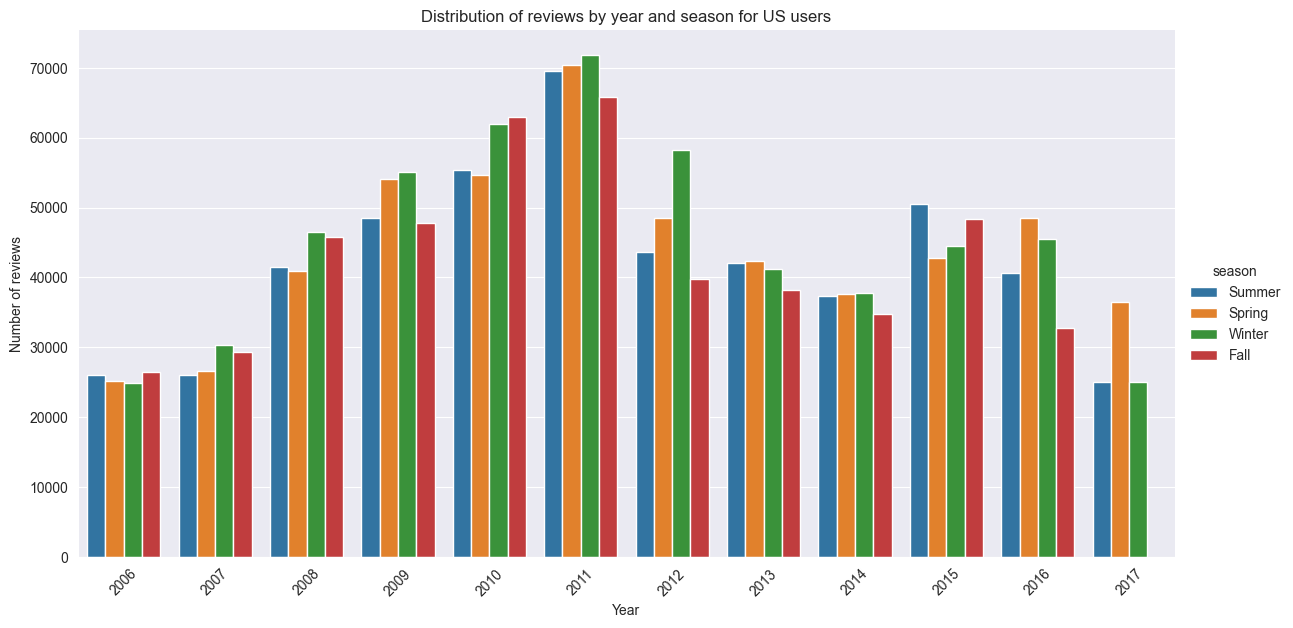

In [50]:
sns.catplot(data=reviews, x='year', hue='season', kind='count', height=6, aspect=2, legend=True)
plt.title('Distribution of reviews by year and season for US users')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.xticks(rotation=45)
plt.show()

Between 2006 and 2017, there is no distinct season with consistently higher review activity, except for notable peaks in Winter 2012 and Spring 2017.

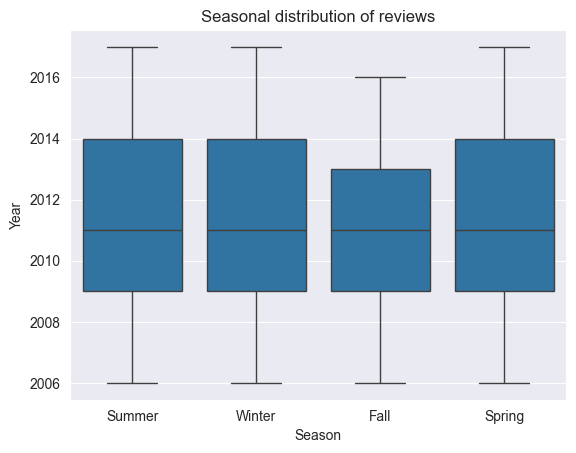

In [51]:
sns.boxplot(x='season', y='year', data=reviews)
plt.title('Seasonal distribution of reviews')
plt.xlabel('Season')
plt.ylabel('Year')
plt.show()

Each season has approximately the same number of reviews.

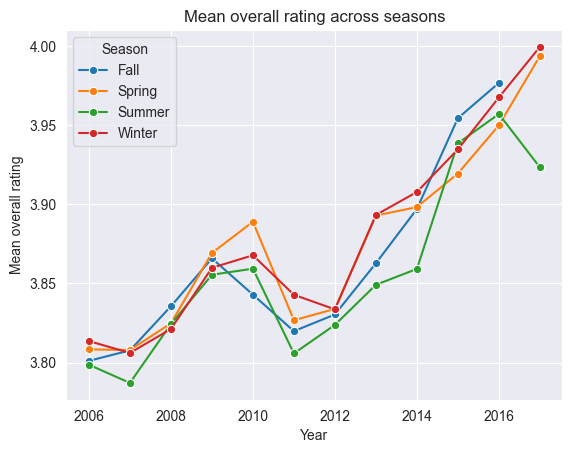

In [52]:
reviews['overall'] = pd.to_numeric(reviews['overall'], errors='coerce')
seasonal_overall = reviews.groupby(['season', 'year'])['overall'].mean().reset_index()

sns.lineplot(data=seasonal_overall, x='year', y='overall', hue='season', marker='o')
plt.title('Mean overall rating across seasons')
plt.xlabel('Year')
plt.ylabel('Mean overall rating')
plt.legend(title='Season')
plt.show()

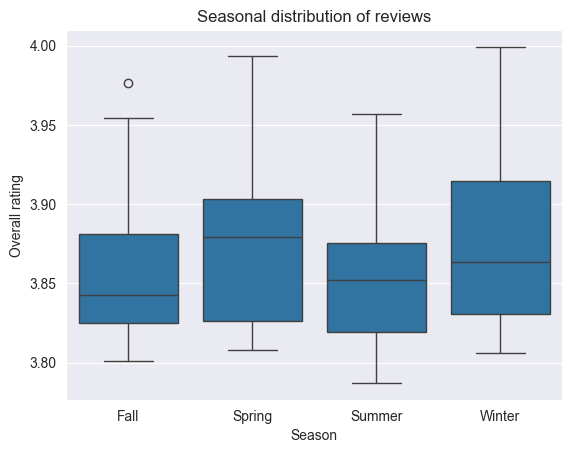

In [53]:
sns.boxplot(x='season', y='overall', data=seasonal_overall)
plt.title('Seasonal distribution of reviews')
plt.xlabel('Season')
plt.ylabel('Overall rating')
plt.show()

## Data analysis 

Average reviews per user by season

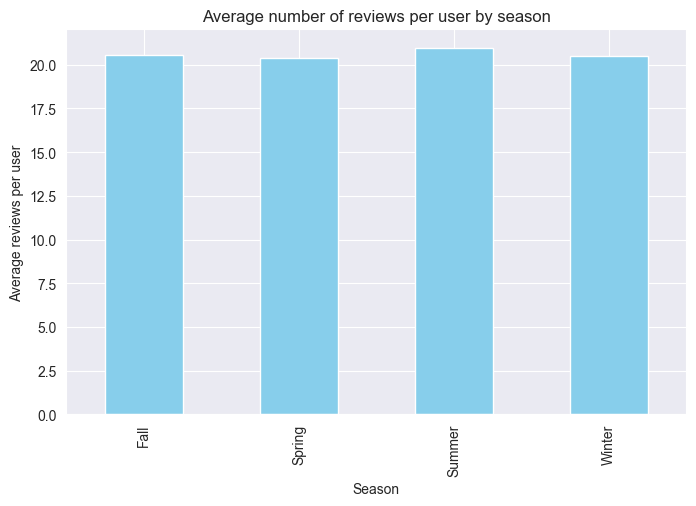

In [55]:
# Group by user and season to calculate the average number of reviews per user in each season
avg_reviews_per_user = reviews.groupby(['user_id', 'season']).size().groupby('season').mean()

plt.figure(figsize=(8, 5))
avg_reviews_per_user.plot(kind='bar', color='skyblue')
plt.title('Average number of reviews per user by season')
plt.xlabel('Season')
plt.ylabel('Average reviews per user')
plt.show()

### Beer Styles by season

In [61]:
# Remove specific words from 'style' column in reviews
reviews['style'] = reviews['style'].str.replace('American ', '')
reviews['style'] = reviews['style'].str.replace('Double / Imperial ', '')
reviews['style'] = reviews['style'].str.replace('English ', '')
reviews['style'] = reviews['style'].str.replace(' (APA)', '', regex=False)

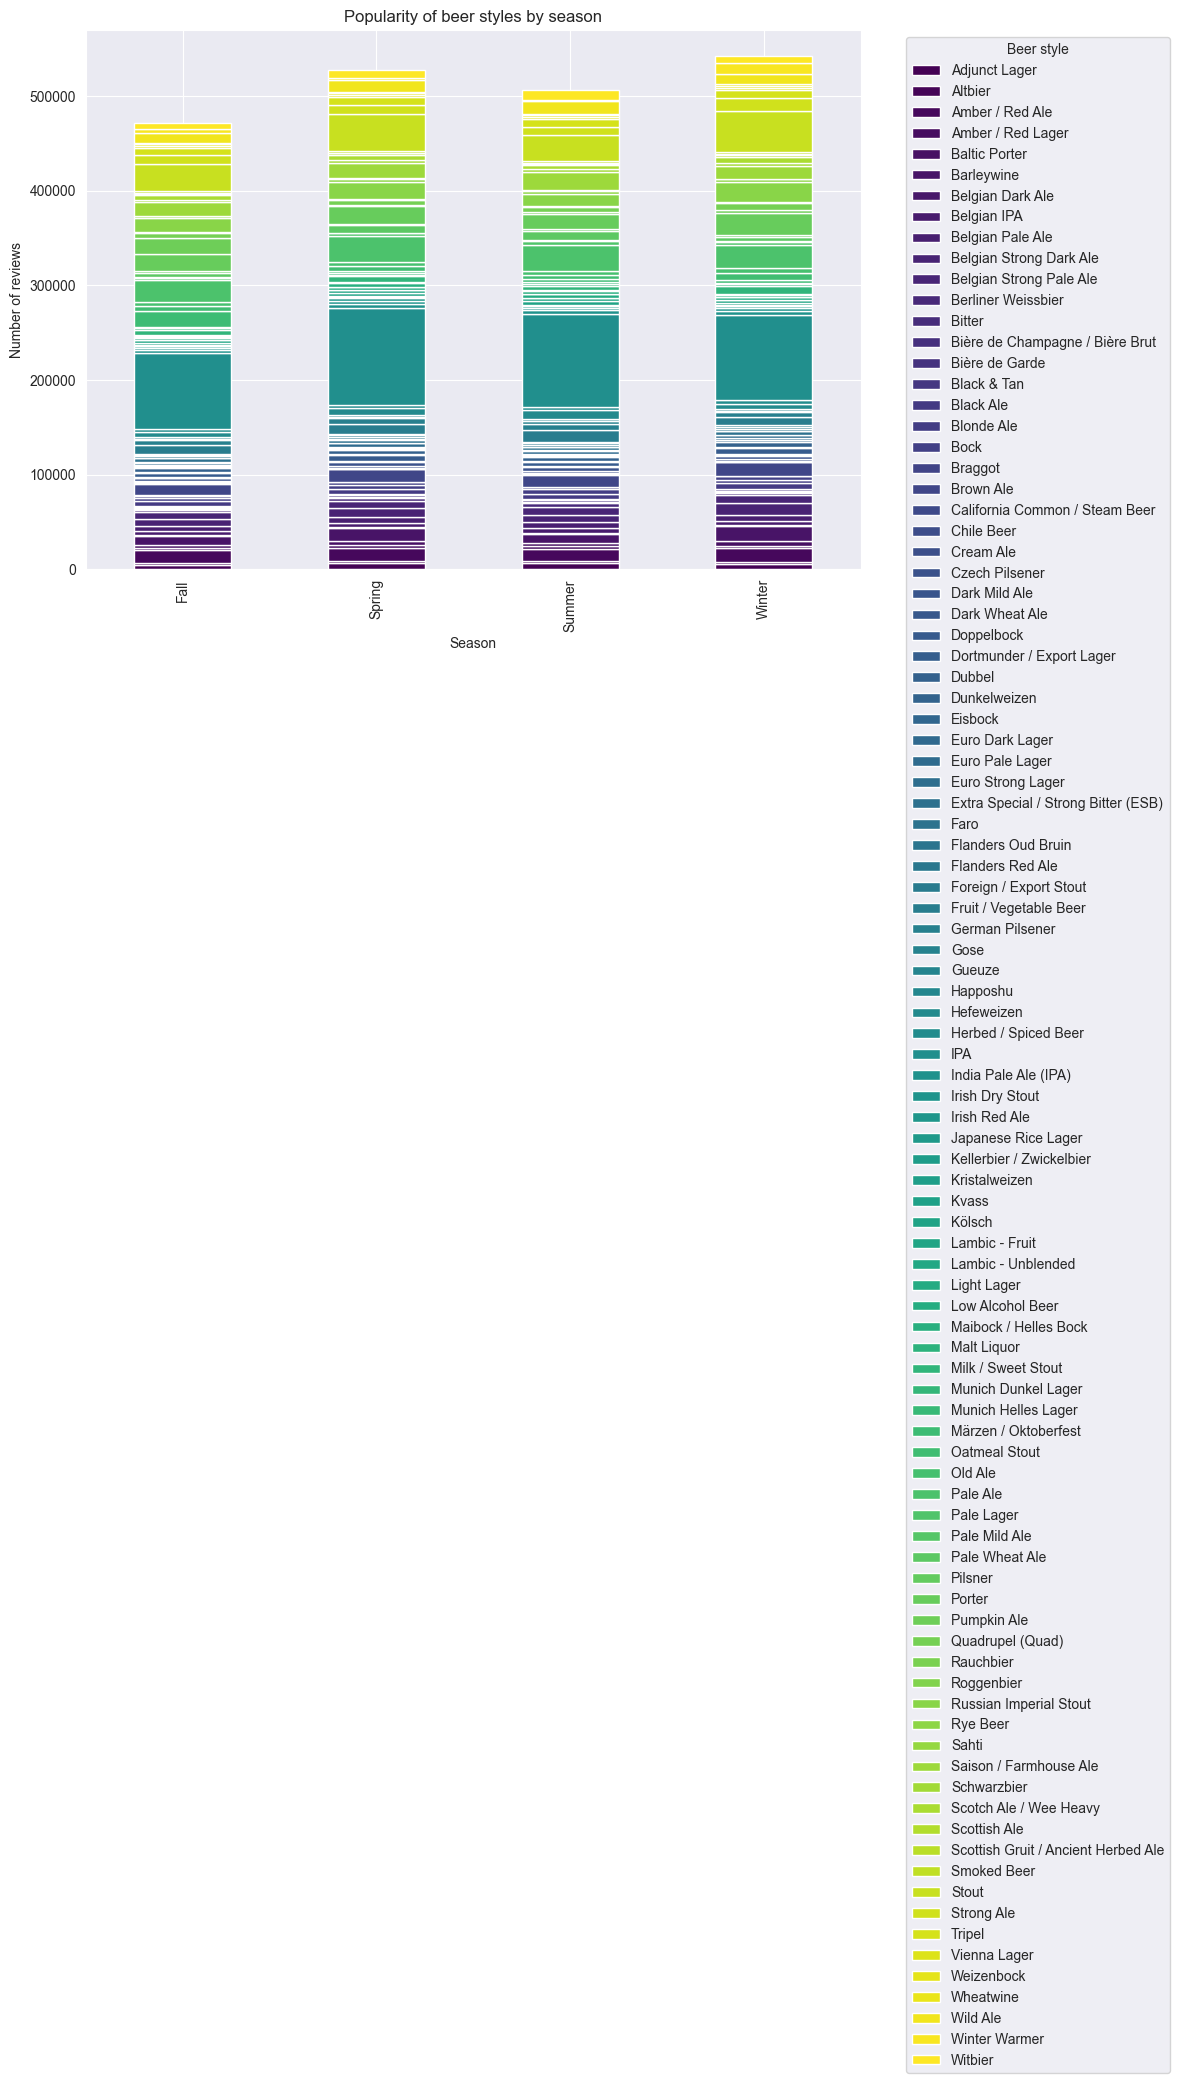

In [62]:
# Count reviews per beer style in each season
style_popularity_by_season = reviews.groupby(['season', 'style']).size().unstack(fill_value=0)

style_popularity_by_season.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='viridis')
plt.title('Popularity of beer styles by season')
plt.xlabel('Season')
plt.ylabel('Number of reviews')
plt.legend(title='Beer style', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()